# Estudio de métodos de control con aproximaciones

Este estudio pertenece a la parte 2 de la práctica 1 correspondiente a la asignatura Extensiones de Machine Learning del máster de IA en la Universidad de Murcia.

El grupo de alumnos que han realizado el estudio está conformado por:

- Tomás Díaz Díaz
- Jose Antonio Sánchez Fernández

## Introducción

Este notebook explora técnicas de aprendizaje por refuerzo que requieren aproximación de funciones:
- SARSA semi-gradiente
- Deep Q-Learning (DQN)

Para la realización del estudio, se utilizará el entorno ***Gymnasium***. Ambas técnicas serán evaluadas en el escenario `CartPole-v1`, consistente en un carro que debe mantener una barra en equilibrio mediante el movimento a izquierda. El espacio de estados en este escenario es continuo y el espacio de acciones es discreto, como veremos durante la creación del entorno. Cada episodio del experimento termina cuando la barra cae o transcurren 500 pasos.

## Imports y configuración

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque
from tqdm import tqdm
import random
import gc

import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('src/')
from AgentSARSASemiGradiente import AgentSARSASemiGradiente
from AgentDeepQLearning import AgentDQLearning
import utils

## Preparación del entorno

In [2]:
# Declaramos una semilla para la reproducibilidad de los resultados y modificación del entorno CartPole
SEMILLA = 42
np.random.seed(SEMILLA) 
np.random.default_rng(SEMILLA)
torch.manual_seed(SEMILLA)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

gc.collect()
torch.cuda.empty_cache()

# Inicializamos el entorno de CartPole
env_name = "CartPole-v1"
sarsa_sg_env = utils.make_env(env_name, seed=SEMILLA)
dql_env = utils.make_env(env_name, seed=SEMILLA)

# TODO Posible sustitución por un Wrapper para observar mejor las dimensiones del entorno
n_episodes = 1000
sarsa_sg_env = gym.wrappers.RecordEpisodeStatistics(sarsa_sg_env, buffer_length=n_episodes)
dql_env = gym.wrappers.RecordEpisodeStatistics(dql_env, buffer_length=n_episodes)

# Usamos el entorno SARSA-SG como ejemplo para obtener las dimensiones del espacio de estados y acciones
state_dim = sarsa_sg_env.observation_space.shape[0]
action_dim = sarsa_sg_env.action_space.n
print(f"Estado: {state_dim} dimensiones, Acciones: {action_dim}")
print(f"Dimensiones: {sarsa_sg_env.observation_space}")

Usando dispositivo: cuda
Estado: 4 dimensiones, Acciones: 2
Dimensiones: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


**¿Qué estamos viendo en este entorno?**

Lo que nos dice esta salida de las características del entorno es que disponemos de 4 dimensiones basadas en las variables que influyen en la localización espacial del carrito, y 2 acciones que podemos realizar con él.
Sobre las dimensiones, por la documentación del escenario concreto, sabemos que consisten en las siguientes:

| Dimensión                    |  Límites mostrados              | Tipo de dato |
|------------------------------|---------------------------------|--------------|
| Posición del carrito (x)     | [-4.8, 4.8]                     | `float32`    |
| Velocidad del carrito (v)    | [-inf, inf]                     | `float32`    |
| Ángulo del poste en radianes | [-0.41887903, 0.41887903]       | `float32`    |
| Velocidad angular del poste  | [-inf, inf]                     | `float32`    |

Estas dimensiones son las que influyen en la cantidad de estados de los que dispondrán nuestros agentes para moverse y alcanzar una política. Sin embargo, al haber variables sin un rango discreto, vemos que habrá una cantidad infinita de estados, por lo que los métodos tabulares dejan de ser viables en un escenario como este. Es por ello que utilizaremos este entorno para demostrar la funcionalidad de los métodos de control por aproximaciones.

## Creación de agentes

In [4]:
sarsa_agent = AgentSARSASemiGradiente(state_dim, action_dim, alpha=0.1, gamma=0.99, epsilon=0.1)

dql_agent = AgentDQLearning(state_dim, action_dim, gamma=0.99, epsilon=0.1)

## Entrenamiento

In [6]:
sarsa_rewards, sarsa_lengths = sarsa_agent.train(sarsa_sg_env, n_episodes=n_episodes)
dql_rewards, dql_lengths = dql_agent.train(dql_env, n_episodes=n_episodes)

# Guardamos estadísticas para las gráficas
training_stats = {
    "SARSA Semi-Gradiente": {
        "rewards": sarsa_rewards,
        "lengths": sarsa_lengths
    },
    "Deep Q-Learning": {
        "rewards": dql_rewards,
        "lengths": dql_lengths
    }
}

## Evaluación

In [10]:
# TODO Graficas recompensas por episodio, rendimiento promedio
def plot_individual_agent(agent_name, rewards, lengths, rolling_window=100):
    moving_avg_rewards = utils.get_moving_avgs(rewards, rolling_window, 'valid')
    moving_avg_lengths = utils.get_moving_avgs(lengths, rolling_window, 'valid')

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].plot(moving_avg_rewards)
    axs[0].set_title(f"{agent_name} - Recompensa Media Móvil")
    axs[0].set_xlabel("Episodio")
    axs[0].set_ylabel("Recompensa")
    axs[0].grid(True)

    axs[1].plot(moving_avg_lengths)
    axs[1].set_title(f"{agent_name} - Longitud del Episodio Media Móvil")
    axs[1].set_xlabel("Episodio")
    axs[1].set_ylabel("Longitud del episodio")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_rewards(training_stats, rolling_window=100):
    plt.figure(figsize=(12, 6))
    for name, stats in training_stats.items():
        moving_avg = utils.get_moving_avgs(stats["rewards"], rolling_window, 'valid')
        plt.plot(moving_avg, label=name)
    plt.title(f"Recompensa media móvil (ventana = {rolling_window})")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa promedio")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_lengths(training_stats, rolling_window=100):
    plt.figure(figsize=(12, 6))
    for name, stats in training_stats.items():
        moving_avg = utils.get_moving_avgs(stats["lengths"], rolling_window, 'valid')
        plt.plot(moving_avg, label=name)
    plt.title(f"Duración media móvil del episodio (ventana = {rolling_window})")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud del episodio")
    plt.grid(True)
    plt.legend()
    plt.show()

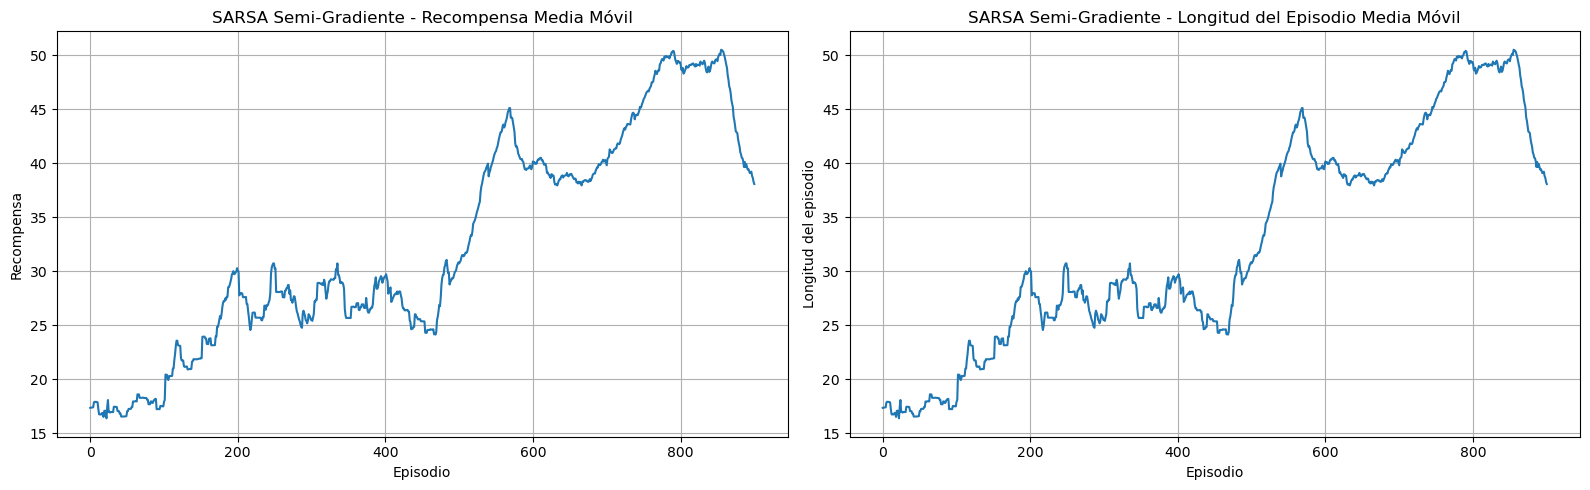

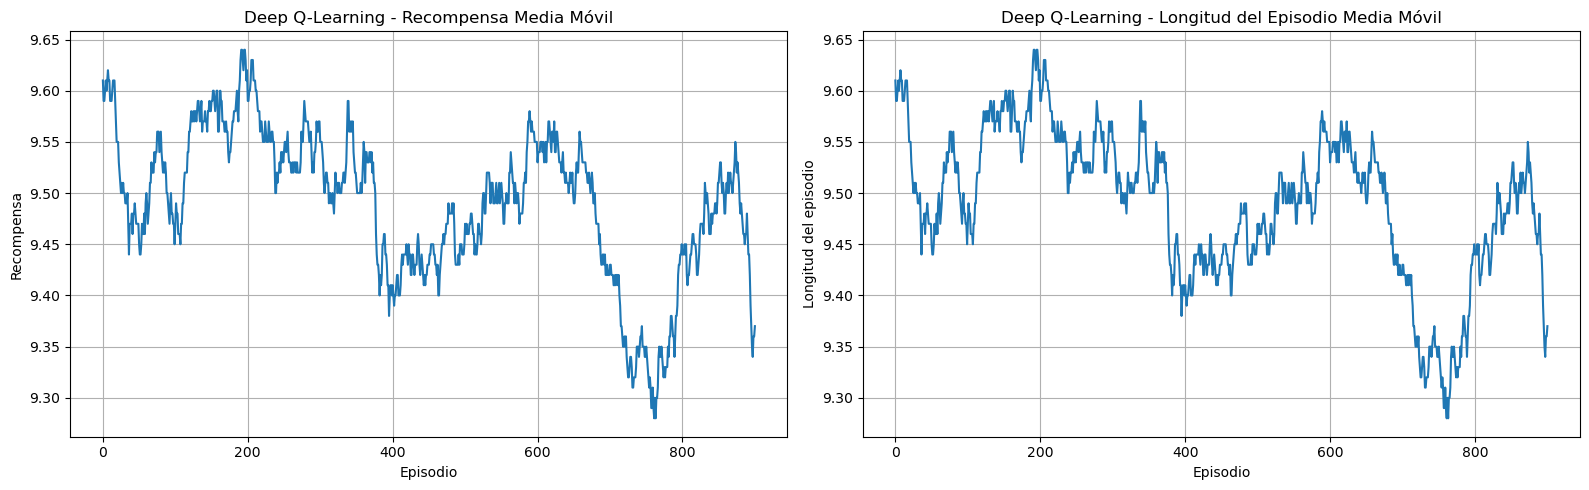

In [11]:
# Mostrar gráficas individuales por agente
for name, stats in training_stats.items():
    plot_individual_agent(name, stats["rewards"], stats["lengths"], rolling_window=100)

## Análisis de resultados

In [ ]:
# TODO Mostrar diferencias en rendimiento y comportamiento